# This notebook is for testing work with PointingGroups

In [1]:
import pointings

%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from astropy import time

In [2]:
# load pointings
pg = pointings.PointingGroups.load("test")

In [3]:
pg.groups = sorted(pg.groups, key=len, reverse=True)
pg[1]

release_date,start_date,date_obs,ra,dec,exposure,product,dtacqnam,filename,visit_id,reprocessing,ingest_folder,imdiff_folder
object,object,object,float64,float64,float64,object,object,object,bytes6,int64,object,object
2016-11-22,2015-05-21,2015-05-22 10:02:49.875,257.649542,-29.259582999999999,40.0,image,/data_local/images/DTS/2013B-0536/DECam_00440415.fits.fz,c4d_150522_100421_ooi_VR_v2.fits.fz,440415,2,r257.649542d-29.259583,imdiff_r257.649542d-29.259583
2016-11-22,2015-05-21,2015-05-22 10:16:57.315,257.65016700000001,-29.258861,40.0,image,/data_local/images/DTS/2013B-0536/DECam_00440427.fits.fz,c4d_150522_101831_ooi_VR_v2.fits.fz,440427,2,r257.649542d-29.259583,imdiff_r257.649542d-29.259583
2016-11-22,2015-05-21,2015-05-22 10:07:38.801,257.65020800000002,-29.259806000000001,40.0,image,/data_local/images/DTS/2013B-0536/DECam_00440419.fits.fz,c4d_150522_100907_ooi_VR_v2.fits.fz,440419,2,r257.649542d-29.259583,imdiff_r257.649542d-29.259583
2016-11-22,2015-05-21,2015-05-22 10:12:16.878,257.65045800000001,-29.260027999999998,40.0,image,/data_local/images/DTS/2013B-0536/DECam_00440423.fits.fz,c4d_150522_101345_ooi_VR_v2.fits.fz,440423,2,r257.649542d-29.259583,imdiff_r257.649542d-29.259583
2016-11-22,2015-05-21,2015-05-22 09:57:57.005,257.65062499999999,-29.258944,40.0,image,/data_local/images/DTS/2013B-0536/DECam_00440411.fits.fz,c4d_150522_095923_ooi_VR_v2.fits.fz,440411,2,r257.649542d-29.259583,imdiff_r257.649542d-29.259583
2016-11-23,2015-05-22,2015-05-23 10:01:46.015,257.65075000000002,-29.254611000000001,40.0,image,/data_local/images/DTS/2013B-0536/DECam_00441044.fits.fz,c4d_150523_100318_ooi_VR_v1.fits.fz,441044,1,r257.649542d-29.259583,imdiff_r257.649542d-29.259583
2016-11-23,2015-05-22,2015-05-23 09:56:56.794,257.65104200000002,-29.254111000000002,40.0,image,/data_local/images/DTS/2013B-0536/DECam_00441040.fits.fz,c4d_150523_095825_ooi_VR_v1.fits.fz,441040,1,r257.649542d-29.259583,imdiff_r257.649542d-29.259583
2016-11-23,2015-05-22,2015-05-23 10:06:57.256,257.65170799999999,-29.254583,40.0,image,/data_local/images/DTS/2013B-0536/DECam_00441048.fits.fz,c4d_150523_100826_ooi_VR_v1.fits.fz,441048,1,r257.649542d-29.259583,imdiff_r257.649542d-29.259583
2016-11-21,2015-05-20,2015-05-21 10:07:16.391,257.65187500000002,-29.259499999999999,40.0,image,/data_local/images/DTS/2013B-0536/DECam_00439711.fits.fz,c4d_150521_100844_ooi_VR_v2.fits.fz,439711,2,r257.649542d-29.259583,imdiff_r257.649542d-29.259583


In [4]:
def plot_pointings(visit_id, ra, dec):
    arcsec2degree = 0.000277778
    pixscale = 0.2637 #arcsec/px
    
    height   = 2048 * pixscale * arcsec2degree
    width    = 4096 * pixscale * arcsec2degree
    angle    = [0]*len(ra)

    fig, ax = plt.subplots(figsize=(13, 9))

    rect_patches = []
    for i, r, d, a in zip(visit_id, ra, dec, angle):
        # this will likely kill the notebook
        #annot = ax.text(r-0.001, d-0.001, i, fontsize=12)
        #                 lower left corner        height  width  angle
        rect = Rectangle((r-height/2., d-width/2.), height, width, a)
        rect_patches.append(rect)
    rect_patches_collection = PatchCollection(rect_patches, alpha=0.1)
    ax.add_collection(rect_patches_collection)

    ax.scatter(ra, dec, color="red")

<IPython.core.display.Javascript object>


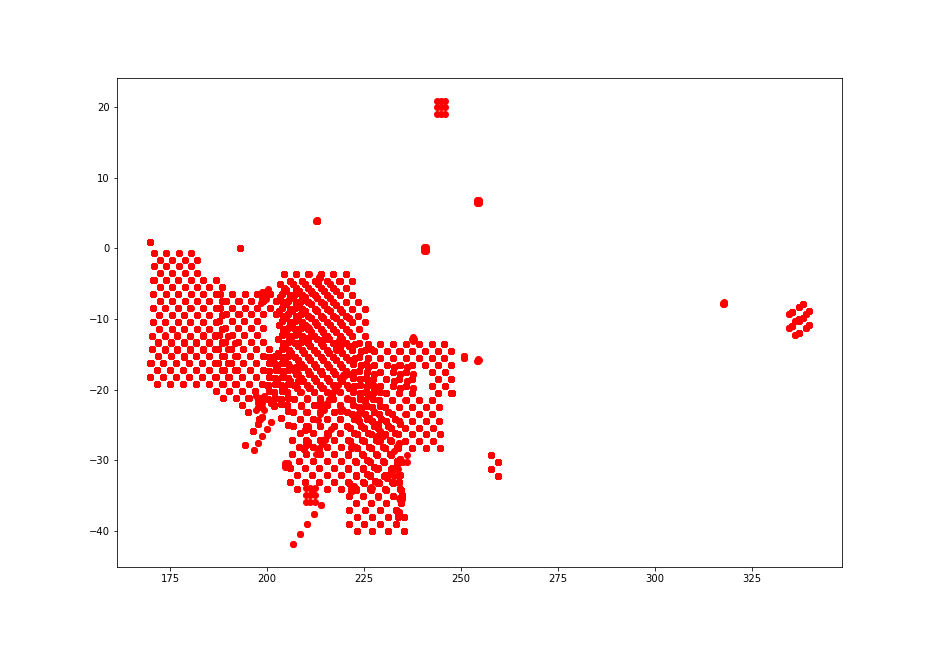

In [5]:
# make a plot of all pointings 
visit_id = pg.table["visit_id"]
ra       = pg.table["ra"]
dec      = pg.table["dec"]
plot_pointings(visit_id, ra, dec)

<IPython.core.display.Javascript object>


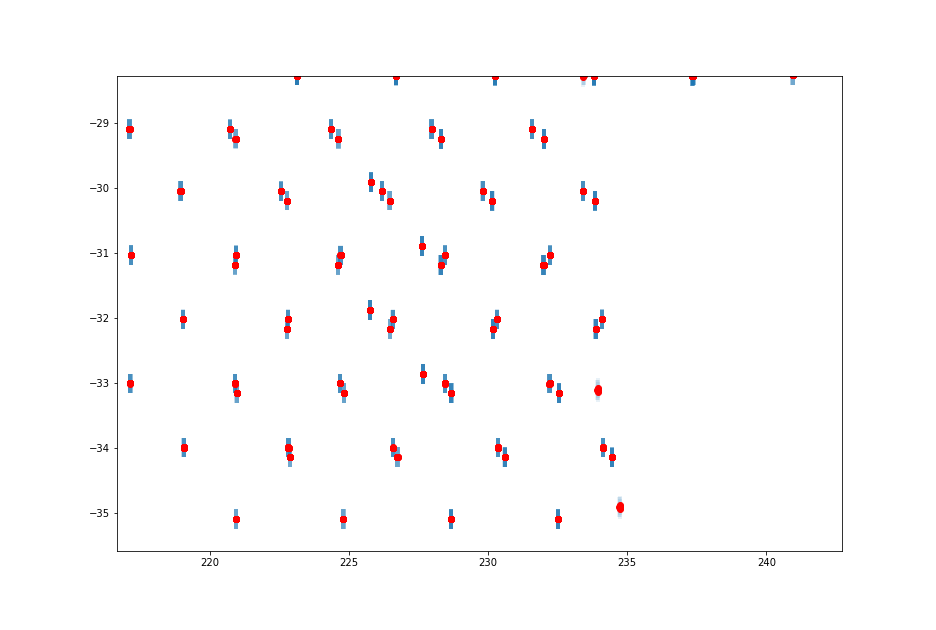

In [15]:
# recreate that plot for grouped pointings only (shouldn't be a lot of difference)
visit_id = pg["visit_id"]
ra       = pg["ra"]
dec      = pg["dec"]
plot_pointings(visit_id, ra, dec)

In [21]:
# Pairs are created from grouped pointings by iterating through all the pointings in a group and calculating the
# time difference dt between two exposures. The pair that has the largest dt will be image differenced. 
# For testing purposes we start from the pointing ra, dec = (207.354958, -7.519750). 
foi = pg[10]
maxdt = time.TimeDelta(0, format="sec")
pairs = []

for science in foi:
    #sci_id, sci_date, sci_ra, sci_dec, sci_filename, sci_night = science[1]
    sci_date = science["date_obs"]
    sci_id = science["visit_id"]
    sci_ra = science["ra"]
    sci_dec = science["dec"]
    sci_filename = science["filename"]
    #sci_night = science["night"]
    sci_date = time.Time(sci_date.decode("utf-8"))
    
    for template in foi: 
        #tmplt_id, tmplt_date, tmplt_ra, tmplt_dec, tmplt_filename, tmplt_night = template[1]
        tmplt_date = science["date_obs"]
        tmplt_id = science["visit_id"]
        tmplt_ra = science["ra"]
        tmplt_dec = science["dec"]
        tmplt_filename = science["filename"]
        tmplt_date = time.Time(tmplt_date.decode("utf-8"))
        
        # dt is a astropy.time.TimeDelta object and can not be compared to non TimeDelta objects
        # it recognizes positive and negative time delta so we check for its absolute value
        dt = sci_date - tmplt_date  
        pair = None
        if abs(dt) > time.TimeDelta(maxdt):
            maxdt = dt
            if science[1]["visit_id"] != template[1]["visit_id"]:
                pair = (science[1], template[1], abs(dt))               
    if pair is not None:
        pairs.append(pair)
    maxdt = time.TimeDelta(0, format="sec")

In [42]:
pg.groups[(pg["ra"] > 207.35498).data]

TypeError: only integer scalar arrays can be converted to a scalar index

In [20]:
# check if all pairs make sense, third columns is the dt in hours
for pair in pairs:
    print(pair[0]["visit_id"], pair[1]["visit_id"], pair[2].sec/60./60.)

In [126]:
# Create the image differencing scripts in folder jobs

rerunpath = "/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/fields/r207.354958d-7.519750/Processed_Data/rerun/singleFrameDriver_rerun"

ncpu = 20
outpath = "imdiff_r207.354958d-7.519750"
cfgfile = "config.py"
cmd = ("imageDifference.py {rerunpath} -j {ncpu} --output {outpath} -C {cfgfile} --longlog "+
       "--timeout 18000 --id visit={visitid} --templateId visit={templateid}\n")

with open("jobs/jobs_specialty.sh", "w") as f:
    for pair in pairs:
        f.write(cmd.format(rerunpath=rerunpath, ncpu=ncpu, outpath=outpath, cfgfile=cfgfile, 
                           visitid=int(pair[0]["visit_id"]), templateid=int(pair[1]["visit_id"])))